# Discrete and Continuous Control with A2C

Reinforcement learning (RL) is the study of agents taking actions in an environment in order to increase their "reward". This takes place in a perception-action-learning loop, whereby the agent receives a state/observation at every timestep, uses its policy to choose an action conditional on this observation, and then receives another observation and a scalar reward as the environment transitions to the next timestep. Through multiple interactions with the environment, the goal of the agent is to improve its policy so that it can maximise its expected cumulative reward.

![RL Loop](https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/action-perception.png)

Unlike the usual supervised or unsupervised learning settings, the agent is responsible for the data it receives, and so it is far from "independent and identically distributed". Furthermore, there is a particularly difficult credit assignment problem - the agent has to work out which of its actions result in rewards, where the rewards caused by specific actions may appear a long time in the future. Nevertheless, RL provides a formal framework for studying this problem.

Here we'll look at the advantage actor-critic (A2C) algorithm, which combines an explicit policy (the actor) with value function estimation (the critic); the value function captures the expected cumulative reward from a given state and given a certain policy, or more informally how good a state is.

We'll look at learning to solve two classic control problems - cartpole and pendulum - using A2C. In contrast to the field of optimal control, we're not assuming that we have access to a (dynamics/forward) model of the environment. RL also includes the concept of model-based methods, which attempt to learn and use such models from data, but that won't be covered here.

## Environments

Firstly we'll instantiate the two environments and see how a random policy performs over several rollouts. This'll give us an idea of the problem to solve, as well as how a naive baseline would perform on it. These are both episodic environments, which means that they can terminate at some point. With cartpole, a random policy fails to keep the pole balanced and episodes terminate quickly. With pendulum, a random policy is unlikely to swing the pole up into the upright position, so episodes time out with low rewards.

Just to note - we'll look at renders of the environment, but the observations for the agents will be a few symbolic inputs, such as the angle of the pole in the cartpole environment. However, the ability to learn policies "end-to-end", i.e., directly from pixels, is one of the major success of deep reinforcement learning.

In [1]:
import math
import gym
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.distributions import Categorical, Normal
from torch.nn import functional as F
from IPython.display import clear_output, display
%matplotlib inline
gym.logger.set_level(50)

'Average reward: 17.80'

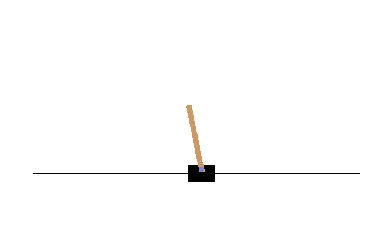

In [69]:
plt.axis('off')

env = gym.make('CartPole-v0')
env.reset()
rollouts = 5
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

for _ in range(rollouts):
    _, done = env.reset(), False
    while not done:
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))

'Average reward: -1142.00'

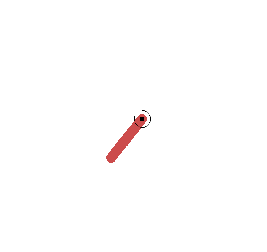

In [70]:
plt.axis('off')

env = gym.make('Pendulum-v0')
env.reset()
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

for _ in range(rollouts):
    _, done = env.reset(), False
    while not done:
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward += reward

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))

## Model

We'll construct a small fully-connected network with one hidden layer for both environments. For discrete control in cartpole (left or right) we'll use a categorical policy, and for continuous control in pendulum (torque) we'll use a Gaussian policy.

In [17]:
class A2C(nn.Module):
    def __init__(self, obs_size, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32, 1 + 2)
        if env == 'pendulum':
            self.var = nn.Parameter(torch.zeros(1, 1))

    def forward(self, obs):
        x = self.fc2(torch.tanh(self.fc1(obs)))
        value, policy = x[:, 0], x[:, 1:]
        if self.env == 'cartpole':
            policy = Categorical(logits=policy)
        elif self.env == 'pendulum':
            policy = Normal(policy[:, 0], F.softplus(self.var).sqrt())
        return policy, value

## Training and Testing

The first part of A2C training involves taking several rollouts in the environment. The environment is reset to start a new episode, and the agent takes actions sampled from its policy until the episode terminates. Meanwhile, we'll need to keep track of the policy, value estimates and rewards encountered at every timestep.

Training here utilises a Monte Carlo approach to estimating the expected return (the expected sum of discounted rewards, where a discount factor in (0, 1) introduces a myopic bias that reduces variance). Forward view? The A2C algorithm actually uses n-step returns, which mixes between Monte Carlo estimates and temporal difference learning - which we'll skip over here.

The value function is trained to estimate the return at each time step, and this can be treated as a regression problem in which the L2 norm between the value function estimate and the actual return is to be minimised. The residual - the difference between the return and the value function estimate - is known as the advantage, or how much better the policy did than expected.

The policy is trained using the REINFORCE rule, also known as the score function estimator. Concretely, the parameters of the policy are updated to increase the log-likelihood of the taken action, weighted by the return. However, the return can have a high variance, so the advantage is utilised instead. It can be shown that using the return minus a baseline (in this case, the estimated value) can reduce the variance, and does not introduce bias if the baseline is independent of the action (in practice, there may be another sort of bias from the value function estimator being inaccurate though). Importantly, we have to use `.detach()` on the `advantage` to make sure that the parameters of the value function estimator are not influenced by the policy gradient loss. Also note that we "subtract" the loss, as we want to perform gradient *ascent* on this, not *descent*.

A2C also uses entropy regularisation, whereby more entropic policies are promoted. This prevents the policy from collapsing into a deterministic solution too soon. Note that this isn't quite the "maximum entropy" principle from RL, as that also requires taking into account the entropy of the policy in future states.

Finally, we'll examine the final policy learned for each environment. If it has learned well then it should be significantly better than the random policies we observed earlier.

'Average final reward: 451.22'

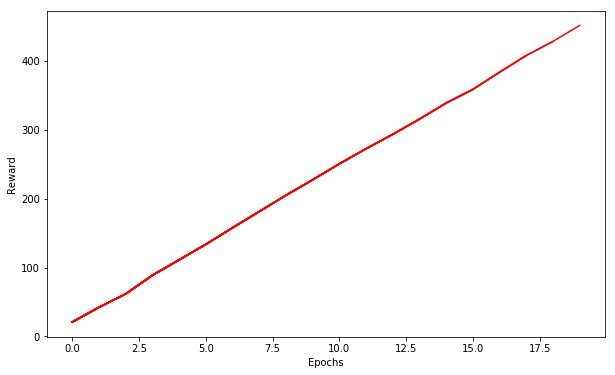

In [5]:
env = gym.make('CartPole-v0')
agent = A2C(4, 'cartpole')
agent.train()
optimiser = optim.RMSprop(agent.parameters(), lr=1e-3)
discount = 0.99
value_loss_weight = 0.5
entropy_loss_weight = 0.01
epochs = 20
rollouts = 32
total_reward, total_rewards = 0, []

plt.figure(figsize=(epochs // 2, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

def plot():
    plt.plot(range(len(total_rewards)), total_rewards, 'r-')
    clear_output(wait=True)
    display(plt.gcf())

optimiser.zero_grad()
for _ in range(epochs):
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        values, log_probs_action, rewards, entropies = [], [], [], []
        while not done:
            policy, value = agent(obs)
            action = policy.sample()
            obs, reward, done, _ = env.step(action.item())
            obs = obs_to_tensor(obs)
            total_reward += reward

            rewards.append(reward)
            values.append(value)
            log_probs_action.append(policy.log_prob(action))
            entropies.append(policy.entropy())

        ep_return = torch.zeros(1, 1)
        trajectory_length = len(rewards)
        loss = 0
        for i in reversed(range(trajectory_length)):
            ep_return = rewards[i] + discount * ep_return
            advantage = ep_return - values[i]
            loss += value_loss_weight * advantage ** 2
            loss -= log_probs_action[i] * advantage.detach()
            loss -= entropy_loss_weight * entropies[i]
        loss.backward()
    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

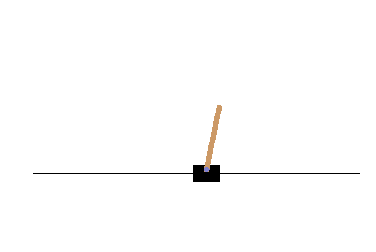

In [7]:
plt.axis('off')

agent.eval()
obs, done = obs_to_tensor(env.reset()), False
view = plt.imshow(env.render(mode='rgb_array'))
while not done:
    view.set_data(env.render(mode='rgb_array'))
    display(plt.gcf())
    clear_output(wait=True)
    with torch.no_grad():
        obs, _, done, _ = env.step(agent(obs)[0].sample().item())
    obs = obs_to_tensor(obs)

env.close()

'Average final reward: -26028.11'

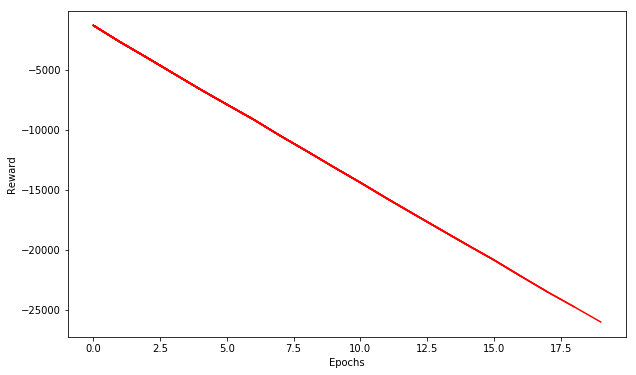

In [18]:
env = gym.make('Pendulum-v0')
agent = A2C(3, 'pendulum')
agent.train()
optimiser = optim.RMSprop(agent.parameters(), lr=1e-3)
entropy_loss_weight = 0.0001
total_reward, total_rewards = 0, []

plt.figure(figsize=(epochs // 2, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

optimiser.zero_grad()
for _ in range(epochs):
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        values, log_probs_action, rewards, entropies = [], [], [], []
        while not done:
            policy, value = agent(obs)
            action = policy.sample()
            obs, reward, done, _ = env.step([action.item()])
            obs = obs_to_tensor(obs)
            total_reward += reward

            rewards.append(reward)
            values.append(value)
            log_probs_action.append(policy.log_prob(action))
            entropies.append(policy.entropy())

        ep_return = torch.zeros(1, 1)
        trajectory_length = len(rewards)
        loss = 0
        for i in reversed(range(trajectory_length)):
            ep_return = rewards[i] + discount * ep_return
            advantage = ep_return - values[i]
            loss += value_loss_weight * advantage ** 2
            loss -= log_probs_action[i] * advantage.detach()
            loss -= entropy_loss_weight * entropies[i]
        loss.backward()  
    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

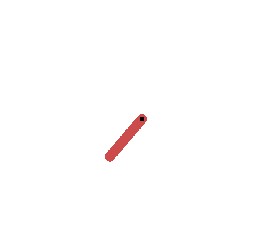

In [19]:
plt.axis('off')

agent.eval()
obs, done = obs_to_tensor(env.reset()), False
view = plt.imshow(env.render(mode='rgb_array'))
while not done:
    view.set_data(env.render(mode='rgb_array'))
    display(plt.gcf())
    clear_output(wait=True)
    with torch.no_grad():
        obs, _, done, _ = env.step([agent(obs)[0].sample().item()])
    obs = obs_to_tensor(obs)

env.close()